## Project goal: Bot Detection

Display advertising is a billion dollar effort and one of the central uses of machine learning on the Internet. However, its data and methods are usually kept under lock and key. In this research project, you will be working on three hours’s worth of [Real-Time Bidding](https://arxiv.org/pdf/1610.03013.pdf) [bid request data](https://docs.bidswitch.com/standards/bid-request-examples.html) and develop models identifying `Sophisticated invalid BOTs traffic (SIVT)`. 

This requirement of this project comes from the AD fraud detection product of one of the renowned [DSP](https://en.wikipedia.org/wiki/Demand-side_platform).

## Potential features targeted here:
 - Idea 1: User_id 
     - Count - Filter the Fraud users who are most active by setting a threshold.
 - Idea 2: User_id and IP 
     - Count - Filter the Fraud users based on count of unique IPs' used by setting a threshold.
 - Idea 3: User_id, Bundle_id and Timestamp 
     - Max Frequency Count - Filter the Fraud users based on number of maximum consecutive hits calculated using First Order Differences.
 - Idea 4: 
     - Frequency Count over short time - Filter the Fraud users based on frequency count of an IP being used by a user in a certrain time spam
 - Idea 5: 
     - Frequency Count over short time - Filter the Fraud users based on frequency count of an bundle_id being used by a user in a certrain time spam
 - Idea 6: IP 
     - Multiple requests from an IP at same Timestamp - Filter the IPs' that sent multiple requests at same timestamp.
     

#### Next Stage Additional features to explore
- Ip Count - count the most used Ips [Most frequent Ip doesn't mean its a bot]
- User using specific ip going to bundle_id - at time intervals (time analysis)
- User going to a bundle id - at time intervals (time analysis)
- Implement a Filtering by stages strategy where in each successive stages of filtering more complex filters are employed
- Implement a ranking/penalty system in which the farther away you are from the mean (expected behavious) more penalty you get

In [61]:
#MODE = "LOCAL"
MODE = "CLUSTER"

import sys
from pyspark.sql import SparkSession
from pyspark import SparkConf
import os
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark import SparkConf
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.storagelevel import StorageLevel

import json
import math
import numbers
import numpy as np
import pandas as pd
import plotly
plotly.offline.init_notebook_mode(connected=True)

sys.path.insert(0,'../../src')
from settings import *

try:
    fh = open('../../libs/pyspark24_py36.zip', 'r')
except FileNotFoundError:
    !aws s3 cp s3://devops.intellinum.co/bins/pyspark24_py36.zip ../../libs/pyspark24_py36.zip
        
try:
    spark.stop()
    print("Stopped a SparkSession")
except Exception as e:
    print("No existing SparkSession")

SPARK_DRIVER_MEMORY= "1G"
SPARK_DRIVER_CORE = "1"
SPARK_EXECUTOR_MEMORY= "1G"
SPARK_EXECUTOR_CORE = "1"
SPARK_EXECUTOR_INSTANCES = 6



conf = None
if MODE == "LOCAL":
    os.environ["PYSPARK_PYTHON"] = "/home/yuan/anaconda3/envs/pyspark24_py36/bin/python"
    conf = SparkConf().\
            setAppName("adtech_bots_detection_rajeev").\
            setMaster('local[*]').\
            set('spark.driver.maxResultSize', '0').\
            set('spark.jars', '../../libs/mysql-connector-java-5.1.45-bin.jar').\
            set('spark.jars.packages','net.java.dev.jets3t:jets3t:0.9.0,com.google.guava:guava:16.0.1,com.amazonaws:aws-java-sdk:1.7.4,org.apache.hadoop:hadoop-aws:2.7.1')
else:
    os.environ["PYSPARK_PYTHON"] = "./MN/pyspark24_py36/bin/python"
    conf = SparkConf().\
            setAppName("adtech_bots_detection_group_1").\
            setMaster('yarn-client').\
            set('spark.executor.cores', SPARK_EXECUTOR_CORE).\
            set('spark.executor.memory', SPARK_EXECUTOR_MEMORY).\
            set('spark.driver.cores', SPARK_DRIVER_CORE).\
            set('spark.driver.memory', SPARK_DRIVER_MEMORY).\
            set("spark.executor.instances", SPARK_EXECUTOR_INSTANCES).\
            set('spark.sql.files.ignoreCorruptFiles', 'true').\
            set('spark.yarn.dist.archives', '../../libs/pyspark24_py36.zip#MN').\
            set('spark.sql.shuffle.partitions', '5000').\
            set('spark.default.parallelism', '5000').\
            set('spark.driver.maxResultSize', '0').\
            set('spark.jars.packages','net.java.dev.jets3t:jets3t:0.9.0,com.google.guava:guava:16.0.1,com.amazonaws:aws-java-sdk:1.7.4,org.apache.hadoop:hadoop-aws:2.7.1'). \
            set('spark.driver.maxResultSize', '0').\
            set('spark.jars', 's3://devops.intellinum.co/bins/mysql-connector-java-5.1.45-bin.jar')
        

spark = SparkSession.builder.\
    config(conf=conf).\
    getOrCreate()


sc = spark.sparkContext

sc.addPyFile('../../src/settings.py')

sc=spark.sparkContext
hadoop_conf = sc._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
hadoop_conf.set("mapreduce.fileoutputcommitter.algorithm.version", "2")

print("Done")

def display(df, limit=10):
    return df.limit(limit).toPandas()

def dfTest(id, expected, result):
    assert str(expected) == str(result), "{} does not equal expected {}".format(result, expected)

Stopped a SparkSession
Done


## Plotly Graphs

In [3]:
# Source - https://stackoverflow.com/questions/36262748/python-save-plotly-plot-to-local-file-and-insert-into-html
from plotly.utils import PlotlyJSONEncoder
from plotly.offline import download_plotlyjs
import json

def plotlyfig2json(fig, fpath=None):
    """
    Serialize a plotly figure object to JSON so it can be persisted to disk.
    Figures persisted as JSON can be rebuilt using the plotly JSON chart API:

    http://help.plot.ly/json-chart-schema/

    If `fpath` is provided, JSON is written to file.

    Modified from https://github.com/nteract/nteract/issues/1229
    """

    redata = json.loads(json.dumps(fig.data, cls=PlotlyJSONEncoder))
    relayout = json.loads(json.dumps(fig.layout, cls=PlotlyJSONEncoder))

    fig_json=json.dumps({'data': redata,'layout': relayout})

    if fpath:
        with open(fpath, 'w') as f:
            f.write(fig_json)
    else:
        return fig_json
    
def plotlyfromjson(fpath):
    """Render a plotly figure from a json file"""
    with open(fpath, 'r') as f:
        v = json.loads(f.read())

    fig = go.Figure(data=v['data'], layout=v['layout'])
    iplot(fig, show_link=False)

In [4]:
import plotly.graph_objs as go

def plot_barchart(dataframe, xValue, yValue, xLabel, yLabel, bar_color='rgba(65, 116, 210, 1)', is_bot='is_bot'):   
    # Creating the plots from the dataframe and x-y values
    fileName = "plots/"+xLabel+" vs "+yLabel
    fileNameHTML = "plots/html/"+xLabel+" vs "+yLabel+".html"
    
    print("Creating the plot . . . .")
    if not isinstance(dataframe, pd.DataFrame):
        dataframe = dataframe.toPandas()
    
    xValue = dataframe[xValue].unique()
    yValue = dataframe[yValue].unique()
    plotData = go.Bar(
                x = xValue,
                y = yValue,
                marker = dict(
                    color = bar_color
#                     color = np.where(dataframe[is_bot] == 'yes', 'rgba(202, 33, 33, 1)', 'rgba(65, 116, 210, 1)')
                    )
            )

    print("Creating the layout . . . .")
    layout = go.Layout(
                title=xLabel+" vs "+yLabel,
                xaxis={
                    "title" : xLabel,
                    "tickfont" : {
                        "size" : 14,
                    }
                },
                yaxis={
                    "title" : yLabel,
                    "tickfont" : {
                        "size" : 10,
                    }
                },
                legend = {
                    "x" : 1,
                    "y" : 1
                },
                bargap=0.15,
#                 barmode='relative'
            )
        
    
    # Actually plotting all the plots
    print("Saving the plot --> "+fileName+" and \n\t\t\t"+fileNameHTML)
    fig = go.Figure(data=[plotData], layout=layout)
#     plotly.offline.iplot(fig)
    plotly.offline.plot(fig, filename = fileNameHTML)
    plotlyfig2json(fig, fileName)

In [5]:
def plot_barchart_grouped(dataframes, xValues, yValues, xLabel, yLabel, plotNames, bar_colors, is_bot='is_bot'):
    no_of_plots = len(dataframes)
    plots = []
    fileName = "plots/"+xLabel+" vs "+yLabel
    fileNameHTML = "plots/html/"+xLabel+" vs "+yLabel+".html"
    
    # Creating the plots from the dataframe and x-y values
    print("Creating the plot . . . .")
    for i in range(no_of_plots):
        dataframe = dataframes[i]
        xValue = dataframe[xValues[i]].unique()
        yValue = dataframe[yValues[i]].unique()
        bar_color = bar_colors[i]
        plotname = plotNames[i]
        plotData = go.Bar(
                    x = xValue,
                    y = yValue,
                    name = plotname,
                    marker = dict(
                        color = bar_color
                    )
                )
        plots.append(plotData)
    
    print('Creating the layout . . . .')
    layout = go.Layout(
                title=xLabel+" vs "+yLabel,
                xaxis={
                    "title" : xLabel,
                    "tickfont" : {
                        "size" : 14,
                    }
                },
                yaxis={
                    "title" : yLabel,
                    "tickfont" : {
                        "size" : 10,
                    }
                },
                legend = {
                    "x" : 1,
                    "y" : 1
                },
                bargap=0.15,
                barmode='group'
            )

    
    # Actually plotting all the plots
    print("Saving the plot --> "+fileName+" and \n\t\t\t"+fileNameHTML)
    fig = go.Figure(data=plots, layout=layout)
#     plotly.offline.iplot(fig)
    plotly.offline.plot(fig, filename = fileNameHTML)
    plotlyfig2json(fig, fileName)

## Read the data
#### Take a sample for further analysis

In [29]:
!aws s3 ls data.intellinum.co/bootcamp/

                           PRE common/


In [31]:
!aws s3 ls --summarize --human-readable --recursive s3://data.intellinum.co/project/

2019-06-12 19:22:21    8 Bytes project/bots_detection/._SUCCESS.crc
2019-06-12 19:22:21   75.5 KiB project/bots_detection/.part-00000-8cb37a22-1996-4848-9967-c64c02f73f86-c000.snappy.parquet.crc
2019-06-12 19:22:21   75.4 KiB project/bots_detection/.part-00001-8cb37a22-1996-4848-9967-c64c02f73f86-c000.snappy.parquet.crc
2019-06-12 19:22:21   75.4 KiB project/bots_detection/.part-00002-8cb37a22-1996-4848-9967-c64c02f73f86-c000.snappy.parquet.crc
2019-06-12 19:22:21   75.5 KiB project/bots_detection/.part-00003-8cb37a22-1996-4848-9967-c64c02f73f86-c000.snappy.parquet.crc
2019-06-12 19:22:21   75.6 KiB project/bots_detection/.part-00004-8cb37a22-1996-4848-9967-c64c02f73f86-c000.snappy.parquet.crc
2019-06-12 19:22:21   75.4 KiB project/bots_detection/.part-00005-8cb37a22-1996-4848-9967-c64c02f73f86-c000.snappy.parquet.crc
2019-06-12 19:22:21   75.6 KiB project/bots_detection/.part-00006-8cb37a22-1996-4848-9967-c64c02f73f86-c000.snappy.parquet.crc
2019-06-12 19:22:21   75.5 KiB project/bots

In [62]:
# Read the data
rtb_bids_stream_df = spark.read.parquet("s3a://data.intellinum.co/project/bots_detection/")

# Create a random sample of the original data
"""
This is the root/default dataframe 
Don't modify this create a new one so this can be reused for replicating stuff fairly easily!
"""
sample_rtb_bids_stream_df = rtb_bids_stream_df.sample(False, 0.1, 99)
sample_rtb_bids_stream_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- bundle_id: string (nullable = true)



In [7]:
# Convert Spark Dataframe to Pandas Dataframe
pandasRTBDF = sample_rtb_bids_stream_df.toPandas()
print("pandasRTBDF df ready")

pandasRTBDF df ready


In [8]:
pandasRTBDF

,user_id,ip,timestamp,bundle_id
0,eef377ff102101fa9df4e193ba6841cee5783b17c7f396...,24.193.253.1,2019-05-01 01:44:23,1737eb67782e191603cc8c7e24dcdc0ec4820aeaab74fe...
1,abdebbe43219b013b94a9f8c01f3c91eebb7a9c21b210c...,174.192.1.211,2019-05-01 01:49:59,26415087a9c86dad3e7b5ca1c234edc4cf3e5214ddec96...
2,9d4ad299ddbf761359f441b6f361e303f9e0c15fab4292...,76.201.1.25,2019-05-01 01:41:06,1737eb67782e191603cc8c7e24dcdc0ec4820aeaab74fe...
3,b30858d2fe5aa2a6f44d85f10ac7421d0de4292076892c...,196.156.70.123,2019-05-01 01:46:20,6b2e278e3ba7d34ef1888120193505acce6cb59c88bb76...
4,55426a1de621d793f177a5cc75bca096215136fc030884...,69.210.2.30,2019-05-01 01:41:38,0e642930432127fd084f13e4fb00b3ecfedc63aa7c78fb...
5,be5dd343df6af2b75a7db6e806aaa28d8d85dd221213fd...,192.69.183.106,2019-05-01 01:44:08,2af4f7eec8e578f7feb8e1af3baeef06a1d50c86a12a68...
6,a68cc47e1d853302cdc8fcead4826a7921f41ff7115ec7...,73.25.222.163,2019-05-01 01:41:57,7764f6f600603b8d4f73b4928500a7f6339738bd21e0f6...
7,10bd0d751a640e55905c448d33bbc2e33f6d5afe950f74...,98.253.192.233,2019-05-01 01:41:50,207946492c0309c739dec11a00f6b5889f65c181c46a57...
8,bd86beff60d78a19f6fdd1ec7bd05924a04765d1301f78...,71.246.199.38,2019-05-01 01:42:04,9d0867eb09992e05e246ef5c36b3a9e9112531e66224ef...
9,62ce45dc22bfae91d91d4dffd0718982ad4d8c043e354f...,71.36.7.108,2019-05-01 01:47:30,3a765c2ecfd64c37ed5e7e8e81799c7250765523390ed1...


In [9]:
userDF = pd.DataFrame({"user_id" : pandasRTBDF["user_id"].unique()})
userDF.count()

user_id    213204
dtype: int64

# Idea 1 - User based Broad Filtering

### Count : Filter the Fraud users who are most active by setting a threshold, this should expose some pretty obvious outliers in the data.

#### Finding the threshold
 - Count the no. of visits made by each user [group by user_id and take count]
 - Find then mean no. of user visits column
 - Find a broad threshold value that filters out most apparent/obvious outliers

In [10]:
pandasRTBDF['user_count'] = pandasRTBDF.groupby('user_id')['user_id'].transform('count')

In [11]:
def tag_suspicious_users_uservisits(df, column, thresh=150):
    """
    For a 'column' find the mean value of that column
    if above threshold mark yes in is_bot else no
    """
    mean = df.loc[:,column].mean()
    df['is_bot'] = np.where(df[column]>= thresh, 'yes', 'no')
    return df

In [12]:
# tag the users bot or not
def tag_user_bot_no_bot(df1, df2, on='user_id', res='is_bot'):
    df2 = df2.groupby(on)[res].agg({lambda x:x.value_counts().index[0]}).reset_index()
    merge = pd.merge(left=df1, right=df2, on=on, how='left')
    merge[res] = merge.apply(lambda x: x[res+'_x'] if x[res+'_x'] == 'yes' else x[res+'_y'], axis=1)
    return merge

In [13]:
# mark is_bot yes if their count is above the set threshold
filtered_users_uservisits = tag_suspicious_users_uservisits(pandasRTBDF, 'user_count', thresh=150)
plot = plot_barchart(filtered_users_uservisits, "user_id", 'user_count', "All Users", 'User Visits')
# plotlyfromjson('plots/All Users vs User Visits')

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/All Users vs User Visits and 
			plots/html/All Users vs User Visits.html


In [14]:
# plot barchart for users marked as bot
bots_uservisits = filtered_users_uservisits.loc[filtered_users_uservisits['is_bot'] == 'yes']
plot_barchart(bots_uservisits, "user_id", 'user_count', "Users[Bots]", 'User Visits', 'rgba(202, 33, 33, 1)' )
# plotlyfromjson('plots/Users[Bots] vs User Visits')

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users[Bots] vs User Visits and 
			plots/html/Users[Bots] vs User Visits.html


In [15]:
# plot barchart for users marked as normal
users_uservisits = filtered_users_uservisits.loc[filtered_users_uservisits['is_bot'] == 'no']
plot_barchart(users_uservisits, "user_id", 'user_count', "Users[Legit]", 'User Visits' ) 
# plotlyfromjson('plots/Users[Legit] vs User Visits')

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users[Legit] vs User Visits and 
			plots/html/Users[Legit] vs User Visits.html


In [16]:
# plot barchart for both set of users - normal vs bots
plot_barchart_grouped([users_uservisits, bots_uservisits], ["user_id", "user_id"],\
              [ 'user_count',  'user_count'],\
              "Users", 'User Visits',\
              ['Users', 'Bots'],\
              ['rgba(65, 116, 210, 1)', 'rgba(202, 33, 33, 1)'] ) 

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users vs User Visits and 
			plots/html/Users vs User Visits.html


In [17]:
# plotlyfromjson('plots/Users vs User Visits')

In [18]:
filtered_users_uservisits

,user_id,ip,timestamp,bundle_id,user_count,is_bot
0,eef377ff102101fa9df4e193ba6841cee5783b17c7f396...,24.193.253.1,2019-05-01 01:44:23,1737eb67782e191603cc8c7e24dcdc0ec4820aeaab74fe...,1,no
1,abdebbe43219b013b94a9f8c01f3c91eebb7a9c21b210c...,174.192.1.211,2019-05-01 01:49:59,26415087a9c86dad3e7b5ca1c234edc4cf3e5214ddec96...,6,no
2,9d4ad299ddbf761359f441b6f361e303f9e0c15fab4292...,76.201.1.25,2019-05-01 01:41:06,1737eb67782e191603cc8c7e24dcdc0ec4820aeaab74fe...,3,no
3,b30858d2fe5aa2a6f44d85f10ac7421d0de4292076892c...,196.156.70.123,2019-05-01 01:46:20,6b2e278e3ba7d34ef1888120193505acce6cb59c88bb76...,1,no
4,55426a1de621d793f177a5cc75bca096215136fc030884...,69.210.2.30,2019-05-01 01:41:38,0e642930432127fd084f13e4fb00b3ecfedc63aa7c78fb...,1,no
5,be5dd343df6af2b75a7db6e806aaa28d8d85dd221213fd...,192.69.183.106,2019-05-01 01:44:08,2af4f7eec8e578f7feb8e1af3baeef06a1d50c86a12a68...,2,no
6,a68cc47e1d853302cdc8fcead4826a7921f41ff7115ec7...,73.25.222.163,2019-05-01 01:41:57,7764f6f600603b8d4f73b4928500a7f6339738bd21e0f6...,1,no
7,10bd0d751a640e55905c448d33bbc2e33f6d5afe950f74...,98.253.192.233,2019-05-01 01:41:50,207946492c0309c739dec11a00f6b5889f65c181c46a57...,1,no
8,bd86beff60d78a19f6fdd1ec7bd05924a04765d1301f78...,71.246.199.38,2019-05-01 01:42:04,9d0867eb09992e05e246ef5c36b3a9e9112531e66224ef...,3,no
9,62ce45dc22bfae91d91d4dffd0718982ad4d8c043e354f...,71.36.7.108,2019-05-01 01:47:30,3a765c2ecfd64c37ed5e7e8e81799c7250765523390ed1...,1,no


In [19]:
# tag the users bot or not
# usersDF = tag_user_bot_no_bot(df1=usersDF, df2=filtered_users_uservisits)

In [20]:
# check the tagged count
# userDF['is_bot'].value_count()

#### Add penalty for User Visits
- Add penalty for deviating from the average number of visits by a user in this time frame
- Penalty = User_visits - average of the visits by all the users in this time frame 

In [21]:
def add_count_penalty(df, column, countNegative=False):
    """
    For a 'column' add a penalty wrt the mean value of that column
    if countNegative is True -ve values are computed otherwise not
    """
    mean = df.loc[:,column].mean()
    print("Mean Value : ", mean)
    if not countNegative:
        df['penalty_'+column] = (np.where(df[column]-mean>0, df[column]-mean, 0)).round().astype('int')
    else:
        df['penalty_'+column] = (df[column]-mean).round().astype('int')
    return df

In [22]:
user_penalty = add_count_penalty(filtered_users_uservisits, 'user_count', True)

Mean Value :  6.299318812818802


In [23]:
# plot barchart to show user over the average number of visits
plot_barchart(user_penalty, "user_id", 'penalty_user_count', "Users", 'Penalty for User Visits')
# plotlyfromjson("plots/Users vs Penalty for User Visits")

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users vs Penalty for User Visits and 
			plots/html/Users vs Penalty for User Visits.html


In [24]:
bot_count = bots_uservisits.user_id.count()
user_count = users_uservisits.user_id.count()

In [25]:
fig = {
  "data": [
    {
      "values": [bot_count, user_count],
      "labels": [
        "Bots",
        "Users"
      ],
      "domain": {"column": 0},
      "name": "Bot vs Users count",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Bot vs Users count",
        "grid": {"rows": 1, "columns": 2},
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Count",
                "x": 0.20,
                "y": 0.5
            }
        ]
    }
}
plotly.offline.iplot(fig, filename='donut')

<h1><center>-------</center></h1>

## Idea 2 - User and IP Analysis

### Count : Filter the Fraud users based on count of unique IPs' used by setting a threshold, this should expose some pretty obvious outliers in the data.

#### Calculation for threshold
 - Count the no. of IP Count for each user [group by user_id and IP and take count]
 - Find then mean no. of IP counts column
 - Find a broad threshold value that filters out most apparent/obvious outliers

In [26]:
def tag_suspicious_users_ipcount(df, column, thresh=150):
    mean = df.loc[:,column].mean()
    thresh = 100
    
    df['is_bot'] = np.where(df[column]>= thresh, 'yes', 'no')
    
    return df

In [27]:
usergroupedbyipcount = pandasRTBDF.groupby(['user_id', 'ip']).size().reset_index(name='ip_count')
usergroupedbyipcount.sort_values(by='ip_count', ascending=False)

,user_id,ip,ip_count
12561,0ea45e6946620025544449249d0446144dcd1f20ab48b1...,197.56.170.191,364
163224,bfa3bd365a1df39e155ce4df8f892bee963dc2897ebce5...,102.184.163.115,158
55303,40d91c495b8ab3e8f7da143a38c7ff16a6d3ae85465451...,173.25.201.45,142
39333,2e2fb781eda9c4f8f28e9e055f813c034f6a5d0d3639ec...,205.201.23.179,134
90827,6a2191e2afdabb367302ab0b08e67446636a6f7663fce9...,73.234.219.218,115
46329,3656d1bed68cb976cf938574b6ac39797d04d6e7f7d6b3...,12.180.143.222,109
40447,2f82764034e95faed096f27cdf7032ab3e93587383adb0...,98.229.64.207,100
215981,fd80cbed51cb7a38da2332c3aef5ffec2c02326c5e746a...,172.58.221.254,90
74540,576531e76644a2474e2d424b80b89f870b49f7ee752159...,97.95.188.182,87
152681,b32fddaab72d1600d6a2afd3dabdc887880d19ca4c469b...,197.165.151.27,84


In [28]:
# mark is_bot yes if their count is above the set threshold
filtered_users_ipcount = tag_suspicious_users_ipcount(usergroupedbyipcount, 'ip_count', True)
plot_barchart(filtered_users_ipcount, "user_id", 'ip_count', "All Users", 'IP counts')


Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/All Users vs IP counts and 
			plots/html/All Users vs IP counts.html


In [29]:
# plotlyfromjson('plots/All Users vs IP counts')

In [30]:
# plot barchart for users marked as bot
bots_ipcount = filtered_users_ipcount.loc[filtered_users_ipcount['is_bot'] == 'yes']
plot_barchart(bots_ipcount, "user_id", 'ip_count', "Users[Bots]", 'IP Counts', 'rgba(202, 33, 33, 1)' )

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users[Bots] vs IP Counts and 
			plots/html/Users[Bots] vs IP Counts.html


In [31]:
# plotlyfromjson('plots/Users[Bots] vs IP counts')

In [32]:
# plot barchart for users marked as normal
users_ipcount = filtered_users_ipcount.loc[filtered_users_ipcount['is_bot'] == 'no']
plot_barchart(users_ipcount, "user_id", 'ip_count', "Users[Legit]", 'IP Counts' ) 

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users[Legit] vs IP Counts and 
			plots/html/Users[Legit] vs IP Counts.html


In [33]:
# plotlyfromjson('plots/Users[Legit] vs IP counts')

In [34]:
# plot barchart for both set of users - normal vs bots
plot_barchart_grouped([users_ipcount, bots_ipcount], ["user_id", "user_id"],\
              [ 'ip_count',  'ip_count'],\
              "Users", 'IP Counts',\
              ['Users', 'Bots'],\
              ['rgba(65, 116, 210, 1)', 'rgba(202, 33, 33, 1)'] ) 

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users vs IP Counts and 
			plots/html/Users vs IP Counts.html


In [35]:
# plotlyfromjson('plots/Users vs IP Counts')

In [36]:
filtered_users_ipcount.sort_values(by='ip_count', ascending=False)

,user_id,ip,ip_count,is_bot
12561,0ea45e6946620025544449249d0446144dcd1f20ab48b1...,197.56.170.191,364,yes
163224,bfa3bd365a1df39e155ce4df8f892bee963dc2897ebce5...,102.184.163.115,158,yes
55303,40d91c495b8ab3e8f7da143a38c7ff16a6d3ae85465451...,173.25.201.45,142,yes
39333,2e2fb781eda9c4f8f28e9e055f813c034f6a5d0d3639ec...,205.201.23.179,134,yes
90827,6a2191e2afdabb367302ab0b08e67446636a6f7663fce9...,73.234.219.218,115,yes
46329,3656d1bed68cb976cf938574b6ac39797d04d6e7f7d6b3...,12.180.143.222,109,yes
40447,2f82764034e95faed096f27cdf7032ab3e93587383adb0...,98.229.64.207,100,yes
215981,fd80cbed51cb7a38da2332c3aef5ffec2c02326c5e746a...,172.58.221.254,90,no
74540,576531e76644a2474e2d424b80b89f870b49f7ee752159...,97.95.188.182,87,no
152681,b32fddaab72d1600d6a2afd3dabdc887880d19ca4c469b...,197.165.151.27,84,no


In [37]:
# userDF = tag_user_bot_no_bot(df1=userDF, df2=filtered_users_ipcount)

In [38]:
# check the tagged count
# userDF['is_bot'].value_count()

#### Add penalty for IP Counts
- Add penalty for deviating from the average number of IP Count for each user in this time frame
- Penalty = User IP count - average of the ip_counts column

In [39]:
ipcount_penalty = add_count_penalty(filtered_users_ipcount, 'ip_count', True)
# ipcount_penalty.sort_values(by='penalty_ip_count')

Mean Value :  1.7050251141028876


In [40]:
plot_barchart(ipcount_penalty, "user_id", 'penalty_ip_count', "Users", 'Penalty for IP Counts')

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users vs Penalty for IP Counts and 
			plots/html/Users vs Penalty for IP Counts.html


In [41]:
# plotlyfromjson('plots/Users vs Penalty fo IP Counts')

In [42]:
bot_count = bots_ipcount.user_id.count()
user_count = users_ipcount.user_id.count()

In [43]:
fig = {
  "data": [
    {
      "values": [bot_count, user_count],
      "labels": [
        "Bots",
        "Users"
      ],
      "domain": {"column": 0},
      "name": "Bot vs Users count",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Bot vs Users count",
        "grid": {"rows": 1, "columns": 2},
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Count",
                "x": 0.20,
                "y": 0.5
            }
        ]
    }
}
plotly.offline.iplot(fig, filename='donut')

<h1><center>-------</center></h1>

## Idea 3 - Max Freq Count for batchwise frequency of FOTD intervals based on user_id grouped with bundle_id 

### Max Frequency Count - Filter the Fraud users based on number of maximum consecutive hits calculated using First Order Differences.


In [ ]:
model_1_path = s3://datata/model_1.pkl
model_1 = sklearn.load(model_1_path)
def model_1_from_batch(series: pd.Series):
    bot_flag =  model_1.predict(series)
    

In [44]:
def timedelta(df, group_columns, sort_columns=[], timestamp_column='timestamp'):
    """
    Calculate the time differences for a group of column
    """
    print(group_columns, sort_columns)
    df['timedelta'] = (df.sort_values(by=sort_columns)\
                                    .groupby(group_columns)[timestamp_column]\
                                    .diff().dt.total_seconds().fillna(0))
    return df

In [45]:
from itertools import groupby
def max_freq_timedelta(df, thresh=2):
    """
    Calculates the max frequency occurance and labels the user as bot or not
    """
    def get_max_freq(row):
        grouped_series = [(k, sum(1 for x in v)) for k, v in groupby(row)]
        occurance = [x[1] for x in grouped_series]
        max_occurance = max(occurance)
        return max_occurance
    
    df['max_freq_time'] = df['first_order_ts_diff'].apply(lambda x: get_max_freq(x))
    df['is_bot'] = df['max_freq_time'].apply(lambda x: True if x > thresh else False)
    return df

In [46]:
pandasRTBDF['timestamp'] = pd.to_datetime(pandasRTBDF['timestamp'])
timedelta_userid_bundleid = timedelta(pandasRTBDF, ['user_id', 'bundle_id'], ['timestamp'], 'timestamp')
timedelta_userid_bundleid

['user_id', 'bundle_id'] ['timestamp']


,user_id,ip,timestamp,bundle_id,user_count,is_bot,penalty_user_count,timedelta
0,eef377ff102101fa9df4e193ba6841cee5783b17c7f396...,24.193.253.1,2019-05-01 01:44:23,1737eb67782e191603cc8c7e24dcdc0ec4820aeaab74fe...,1,no,-5,0.0
1,abdebbe43219b013b94a9f8c01f3c91eebb7a9c21b210c...,174.192.1.211,2019-05-01 01:49:59,26415087a9c86dad3e7b5ca1c234edc4cf3e5214ddec96...,6,no,0,225.0
2,9d4ad299ddbf761359f441b6f361e303f9e0c15fab4292...,76.201.1.25,2019-05-01 01:41:06,1737eb67782e191603cc8c7e24dcdc0ec4820aeaab74fe...,3,no,-3,348.0
3,b30858d2fe5aa2a6f44d85f10ac7421d0de4292076892c...,196.156.70.123,2019-05-01 01:46:20,6b2e278e3ba7d34ef1888120193505acce6cb59c88bb76...,1,no,-5,0.0
4,55426a1de621d793f177a5cc75bca096215136fc030884...,69.210.2.30,2019-05-01 01:41:38,0e642930432127fd084f13e4fb00b3ecfedc63aa7c78fb...,1,no,-5,0.0
5,be5dd343df6af2b75a7db6e806aaa28d8d85dd221213fd...,192.69.183.106,2019-05-01 01:44:08,2af4f7eec8e578f7feb8e1af3baeef06a1d50c86a12a68...,2,no,-4,0.0
6,a68cc47e1d853302cdc8fcead4826a7921f41ff7115ec7...,73.25.222.163,2019-05-01 01:41:57,7764f6f600603b8d4f73b4928500a7f6339738bd21e0f6...,1,no,-5,0.0
7,10bd0d751a640e55905c448d33bbc2e33f6d5afe950f74...,98.253.192.233,2019-05-01 01:41:50,207946492c0309c739dec11a00f6b5889f65c181c46a57...,1,no,-5,0.0
8,bd86beff60d78a19f6fdd1ec7bd05924a04765d1301f78...,71.246.199.38,2019-05-01 01:42:04,9d0867eb09992e05e246ef5c36b3a9e9112531e66224ef...,3,no,-3,0.0
9,62ce45dc22bfae91d91d4dffd0718982ad4d8c043e354f...,71.36.7.108,2019-05-01 01:47:30,3a765c2ecfd64c37ed5e7e8e81799c7250765523390ed1...,1,no,-5,0.0


In [47]:
# Calculate the first order time differences
fod_user_bundle = pd.DataFrame()
fod_user_bundle['first_order_ts_diff'] = timedelta_userid_bundleid.groupby(['user_id', 'bundle_id'])['timedelta'].apply(list)
fod_user_bundle

,,first_order_ts_diff
user_id,bundle_id,
00003ad85c0b6e578aa3ac43164284af07f4457d1252771070816071a35f9045,e297a6a957e2884c47915529660c7464c92a9d63805cdf7550ef78ec3ac50980,[0.0]
000091f8c241a0a7cca79848b78056ff67dabdbeca47141da858f9444fdc2c1d,2cb61c63cfcb2a048b48e982c62efae692a859257313ffc67b548548234dc4cf,[0.0]
0000fccaf5b564f00a1166bd3a29efd52d280c446ce52073851e38c3cfbba717,4caf52ca68b3aaf033beee427bec573c121982f7e958e8d512acbe7d45d5f224,[0.0]
0001640c147ac134b179db1d688971c1280a5b2e91bd9bf2d1bd93c72e200e75,1737eb67782e191603cc8c7e24dcdc0ec4820aeaab74fe3c29d38c48d2e71c6f,[0.0]
0001cebca2c5f7667a7b3be0ab0009cecca098909287be981516b9c2085324a0,8fe09d92a766677b76f8cc154db689ad22c332259b78760373a3f6bb03bcef78,[0.0]
0001d310eb491b2b74eebeae078253aab87743b804c74b4847e9e79efa8163c3,55f6136a48fa40ee8a872fd6a028ac5ce47d87d0c122a3c49624f333530ea7ac,[0.0]
0001e4146fe4f501e0c1bd9f4648e7f72784411f14b7109c316e379a23a4af1b,3dd3193dcb62c7f0a6f0c243791d2a30f4d13a106284ceaba41f747cf8256fc5,[0.0]
00022e65fcb345611bab9903ac59cab2c5013a66310c6797b94de6cd78c4d492,4caf52ca68b3aaf033beee427bec573c121982f7e958e8d512acbe7d45d5f224,[0.0]
0002c0bdc8bbebb1f3dfcabaccb1901f67b42ed0fb42867a4cc25c305c1466fe,971d676c98e18e49a59077f79b4bc059a99440145eb2d7266133b3d978302d85,[0.0]


In [48]:
def display(user_range):
    traces = []
    fod_user_bundle.reset_index(level=0)
    i = user_range[0]
    for idx, row in fod_user_bundle.iterrows():
        i += 1
        if i < user_range[1]:
            trace = go.Scatter(
                            x = [i]*len(row.first_order_ts_diff),
                            y = row.first_order_ts_diff,
                            mode = 'markers'
                            )
            traces.append(trace)
        else:
            break
            
    layout = go.Layout(
        title='First Order Differences vs Users grouped with bundle id',
        yaxis=dict(
            title='First Order Differences'
        ),
        xaxis=dict(
            title='Users'
        )
    )
    fig = go.Figure(data=traces, layout=layout)
    plotly.offline.iplot(fig, filename='FOTD vs Users')
    plotly.offline.plot(fig, filename='plots/html/FOTD vs Users.html')    

In [49]:
display([1000,1100])

In [50]:
from itertools import groupby
def helper_bfct(df, column, thresh=2):
    def get_freq(arr):
        count_freq = [sum(1 for _ in group) for _, group in groupby(arr)]
        return max(count_freq)
    
    df['batchwise_freq_ti'] = df[column].apply(lambda x : get_freq(x))
#     df['is_bot'] = df['batchwise_freq_ti'].apply(lambda x: True if x > thresh else False)
    df['is_bot'] = np.where(df['batchwise_freq_ti'] >= thresh, 'yes', 'no')
    
    return df

In [51]:
batchwise_freq_consecutive_timeintervals = helper_bfct(fod_user_bundle, 'first_order_ts_diff')

In [52]:
batchwise_freq_consecutive_timeintervals = batchwise_freq_consecutive_timeintervals.reset_index()
batchwise_freq_consecutive_timeintervals.sort_values(by="batchwise_freq_ti", ascending = False)

,user_id,bundle_id,first_order_ts_diff,batchwise_freq_ti,is_bot
36318,2b102a72056c7634246465a624d81547862bab3fd329ab...,55f6136a48fa40ee8a872fd6a028ac5ce47d87d0c122a3...,"[1486.0, 150.0, 90.0, 8077.000000000001, 15.00...",4,yes
91572,6bf46a384af034eb9475fc1785c39edf01d073cabe0f1a...,55f6136a48fa40ee8a872fd6a028ac5ce47d87d0c122a3...,"[600.0, 180.0, 255.00000000000003, 60.00000000...",3,yes
33488,27b86937660c48d47ee2115aec681640507a2647175368...,55f6136a48fa40ee8a872fd6a028ac5ce47d87d0c122a3...,"[28.0, 135.0, 450.0, 15.000000000000002, 15.00...",3,yes
205095,f3211c18cdb75d7ed41765fc5e7798ffe36d0434fae1d6...,2f5fe763f1ec44e6bd4ef9a2238841e986696c3747b955...,"[5.0, 5.0, 30.000000000000004, 1604.0, 25.0, 1...",3,yes
201079,ee5e75fcb55401b81ad077564f55e056a5377d5004b7da...,a761b8c9612ff9e2c0706ef95b90ade51147cd1d00faa2...,"[740.0, 90.0, 840.0, 0.0, 160.0, 60.0000000000...",3,yes
213947,fd80cbed51cb7a38da2332c3aef5ffec2c02326c5e746a...,2f5fe763f1ec44e6bd4ef9a2238841e986696c3747b955...,"[10.0, 14.0, 26.0, 109.0, 30.000000000000004, ...",3,yes
86624,664add2c4307e92e7e4565888d59cfa671d1d0e5b123f4...,a761b8c9612ff9e2c0706ef95b90ade51147cd1d00faa2...,"[20.0, 20.0, 20.0, 370.0, 0.0]",3,yes
175071,cf63727fc9a61b2127599613513f25c980a6e514c21450...,55f6136a48fa40ee8a872fd6a028ac5ce47d87d0c122a3...,"[45.0, 45.0, 61.00000000000001, 45.0, 435.0, 0...",2,yes
160228,bde4f1cc49a7ee1a49c580817b41ce2672f63832a5fa5d...,05b5aa845aabadd11dac8052f770ec5b23c887e6ae78b0...,"[0.0, 261.0, 313.0, 60.00000000000001, 60.0000...",2,yes
170025,c977b0637c422698467daceb14ff00d739988305837ca6...,55f6136a48fa40ee8a872fd6a028ac5ce47d87d0c122a3...,"[150.0, 0.0, 745.0, 360.0, 144.0, 31.000000000...",2,yes


In [53]:
plot_barchart(batchwise_freq_consecutive_timeintervals, "user_id", 'batchwise_freq_ti', "Users", 'Consecutive Time Interval Frequency')

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users vs Consecutive Time Interval Frequency and 
			plots/html/Users vs Consecutive Time Interval Frequency.html


In [54]:
bots_ti_freq = batchwise_freq_consecutive_timeintervals.loc[batchwise_freq_consecutive_timeintervals['is_bot'] == 'yes']
plot_barchart(bots_ti_freq, "user_id", 'batchwise_freq_ti', "Users[Bots]", 'Max Freq of batchwise consecutive FOTD intervals', 'rgba(202, 33, 33, 1)' )

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users[Bots] vs Max Freq of batchwise consecutive FOTD intervals and 
			plots/html/Users[Bots] vs Max Freq of batchwise consecutive FOTD intervals.html


In [55]:
users_ti_freq = batchwise_freq_consecutive_timeintervals.loc[batchwise_freq_consecutive_timeintervals['is_bot'] == 'no']
plot_barchart(users_ti_freq, "user_id", 'batchwise_freq_ti', "Users[Legit]", 'Max Freq of batchwise consecutive FOTD intervals' ) 

Creating the plot . . . .
Creating the layout . . . .
Saving the plot --> plots/Users[Legit] vs Max Freq of batchwise consecutive FOTD intervals and 
			plots/html/Users[Legit] vs Max Freq of batchwise consecutive FOTD intervals.html


In [56]:
bot_count = bots_ti_freq.user_id.count()
bot_count

674

In [57]:
user_count = users_ti_freq.user_id.count()
user_count

215278

In [58]:
fig = {
  "data": [
    {
      "values": [bot_count, user_count],
      "labels": [
        "Bots",
        "Users"
      ],
      "domain": {"column": 0},
      "name": "Bot vs Users count",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Bot vs Users count",
        "grid": {"rows": 1, "columns": 2},
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Count",
                "x": 0.20,
                "y": 0.5
            }
        ]
    }
}
plotly.offline.iplot(fig, filename='donut')

<h1><center>-------</center></h1>

## Idea - 4 Frequency Count over short time - Filter the Fraud users based on frequency count of an IP being used by a user in a certrain time spam

#### Calculation for threshold
 - Find the users that uses multiple IPs and there corresponding time difference[group by user_id and IP and find the time lag]
 - Find a broad threshold value that filters out most apparent/obvious outliers

In [63]:
from pyspark.sql.functions import sum as sum_, lag, col, coalesce, lit
from pyspark.sql.window import Window
overCategory = Window.partitionBy('user_id').orderBy('ip').orderBy('bundle_id').orderBy('timestamp')
df = sample_rtb_bids_stream_df.withColumn(
  "timelag", lag('timestamp').over(overCategory)).withColumn(
  "iplag", lag('ip').over(overCategory)).withColumn(
  "bundlelag", lag('bundle_id').over(overCategory)).select("user_id","ip","bundle_id","timestamp", "timelag","iplag","bundlelag")
display(df)
#display(fod)

,user_id,ip,bundle_id,timestamp,timelag,iplag,bundlelag
0,0812d9ffbac8cf3963c731e3ce3ea69534df3d0096060f...,73.119.82.95,f2d54bdc4e8293b82581cdb315600b439ba0326715ffc3...,2019-05-01 02:58:03,None,None,None
1,09269d493d8c3401ef9b9acdd54c164cdb69b30d1a255b...,100.12.181.251,902bd6a84758de8b9c644162a1352f983a8c5adc192af3...,2019-05-01 01:47:38,None,None,None
2,0a28f0b098234193450aa45abbded8bfd2cfdec9d769fb...,166.137.14.113,297d6cd809fbcf2637f340ead233cb43040c2094ecad7e...,2019-05-01 03:40:17,None,None,None
3,1bf8a63780946ef50cd2ed389fec3c94dbb30ccda495d8...,166.137.126.24,12813e8e8367762b61a1ac2cd7138634d709a13817d9aa...,2019-05-01 01:41:54,None,None,None
4,2bb275399b0dc926397e371ee3bf8821b418dc59f1e32c...,2.50.182.78,971d676c98e18e49a59077f79b4bc059a99440145eb2d7...,2019-05-01 04:04:52,None,None,None
5,2d46ad819fac06d2e5cba4cff5010e7a04d9c40b93a227...,172.250.112.133,26415087a9c86dad3e7b5ca1c234edc4cf3e5214ddec96...,2019-05-01 01:54:36,None,None,None
6,31bd37c7e0176c6b2be05e3636b151e52f535f69a4adf9...,174.206.28.91,55f6136a48fa40ee8a872fd6a028ac5ce47d87d0c122a3...,2019-05-01 01:41:41,None,None,None
7,3b55bab50a8ff3b5dd8da7f69405dbce010396b5fefcfe...,181.49.64.80,2bb8cbdd19badd7750b793e5860205d8f3e89e3bd1b576...,2019-05-01 02:58:18,None,None,None
8,3b55bab50a8ff3b5dd8da7f69405dbce010396b5fefcfe...,190.157.202.46,2bb8cbdd19badd7750b793e5860205d8f3e89e3bd1b576...,2019-05-01 03:07:30,2019-05-01 02:58:18,181.49.64.80,2bb8cbdd19badd7750b793e5860205d8f3e89e3bd1b576...
9,3b55bab50a8ff3b5dd8da7f69405dbce010396b5fefcfe...,186.154.196.226,2bb8cbdd19badd7750b793e5860205d8f3e89e3bd1b576...,2019-05-01 03:12:10,2019-05-01 03:07:30,190.157.202.46,2bb8cbdd19badd7750b793e5860205d8f3e89e3bd1b576...


In [64]:
timeFmt = "yyyy-MM-dd' 'HH:mm:ss"
timeDiff = (F.unix_timestamp('timestamp', format=timeFmt)
            - F.unix_timestamp('timelag', format=timeFmt))
df2 = df.withColumn("timefod", timeDiff).withColumn('ipfod', F.when((F.col("ip") == F.col("iplag")), 1).otherwise(2)).withColumn('bundlefod', F.when((F.col("bundle_id") == F.col("bundlelag")), 1).otherwise(2))
display(df2)
ipfraud= df2.select("user_id","ip","timestamp","ipfod","timefod")

In [66]:
fraud2=ipfraud.filter("ipfod == '2' AND timefod <180")
display(fraud2)

,user_id,ip,timestamp,ipfod,timefod
0,447f3eef27865de54c79a9efebcae58a3c552bd7cea148...,208.54.37.206,2019-05-01 04:46:34,2,133
1,ee2d7d8e07181f2b88f6fa8e10c593faadc641e659f6a7...,94.204.207.205,2019-05-01 04:00:48,2,21
2,8e6285b8cb66b89a9296af4865b68cb084faf5951722ee...,54.145.176.239,2019-05-01 04:42:50,2,103
3,8e6285b8cb66b89a9296af4865b68cb084faf5951722ee...,73.227.193.50,2019-05-01 04:42:53,2,3
4,a4bfda565e6143235c02141dc8912f87269ab11e4207b0...,66.87.149.169,2019-05-01 02:28:18,2,113
5,b73f869a4c4bbf302417618495be25d7cc44a46629be9f...,149.135.146.51,2019-05-01 04:51:18,2,95
6,b73f869a4c4bbf302417618495be25d7cc44a46629be9f...,1.129.110.47,2019-05-01 04:52:14,2,56
7,ea1b66f647ab9c64370d355ac0829327c7669fc9eac013...,172.58.109.201,2019-05-01 00:28:26,2,34
8,ea1b66f647ab9c64370d355ac0829327c7669fc9eac013...,72.177.131.41,2019-05-01 00:28:43,2,17
9,ea1b66f647ab9c64370d355ac0829327c7669fc9eac013...,72.177.131.41,2019-05-01 01:08:46,2,61


Text(0, 0.5, 'number of requests with very short IP switch time')

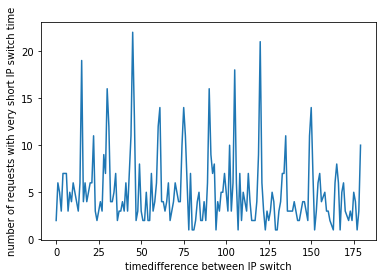

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
ipplot=fraud2.groupby("timefod").count().orderBy("timefod",ascending=True)
plotip_pandas = ipplot.toPandas()
y_pos= plotip_pandas['count']
x= plotip_pandas['timefod']
plt.plot(x,y_pos)
plt.xlabel('timedifference between IP switch')
plt.ylabel('number of requests with very short IP switch time')

<h1><center>-------</center></h1>

## Idea - 5 Frequency Count over short time - Filter the Fraud users based on frequency count of an bundle_id being used by a user in a certrain time spam

#### Calculation for threshold
 - Find the users that uses multiple bundle_id and there corresponding time difference[group by user_id and bundle_id and find the time lag]
 - Find a broad threshold value that filters out most apparent/obvious outliers

In [68]:
from pyspark.sql import functions as F
timeFmt = "yyyy-MM-dd' 'HH:mm:ss"
timeDiff = (F.unix_timestamp('timestamp', format=timeFmt)
            - F.unix_timestamp('timelag', format=timeFmt))
df2w = df.withColumn("timefod", timeDiff).withColumn('bundlefod', F.when((F.col("bundle_id") == F.col("bundlelag")), 1).otherwise(2))
display(df2w)

,user_id,ip,bundle_id,timestamp,timelag,iplag,bundlelag,timefod,bundlefod
0,0812d9ffbac8cf3963c731e3ce3ea69534df3d0096060f...,73.119.82.95,f2d54bdc4e8293b82581cdb315600b439ba0326715ffc3...,2019-05-01 02:58:03,None,None,None,NaN,2
1,09269d493d8c3401ef9b9acdd54c164cdb69b30d1a255b...,100.12.181.251,902bd6a84758de8b9c644162a1352f983a8c5adc192af3...,2019-05-01 01:47:38,None,None,None,NaN,2
2,0a28f0b098234193450aa45abbded8bfd2cfdec9d769fb...,166.137.14.113,297d6cd809fbcf2637f340ead233cb43040c2094ecad7e...,2019-05-01 03:40:17,None,None,None,NaN,2
3,1bf8a63780946ef50cd2ed389fec3c94dbb30ccda495d8...,166.137.126.24,12813e8e8367762b61a1ac2cd7138634d709a13817d9aa...,2019-05-01 01:41:54,None,None,None,NaN,2
4,2bb275399b0dc926397e371ee3bf8821b418dc59f1e32c...,2.50.182.78,971d676c98e18e49a59077f79b4bc059a99440145eb2d7...,2019-05-01 04:04:52,None,None,None,NaN,2
5,2d46ad819fac06d2e5cba4cff5010e7a04d9c40b93a227...,172.250.112.133,26415087a9c86dad3e7b5ca1c234edc4cf3e5214ddec96...,2019-05-01 01:54:36,None,None,None,NaN,2
6,31bd37c7e0176c6b2be05e3636b151e52f535f69a4adf9...,174.206.28.91,55f6136a48fa40ee8a872fd6a028ac5ce47d87d0c122a3...,2019-05-01 01:41:41,None,None,None,NaN,2
7,3b55bab50a8ff3b5dd8da7f69405dbce010396b5fefcfe...,181.49.64.80,2bb8cbdd19badd7750b793e5860205d8f3e89e3bd1b576...,2019-05-01 02:58:18,None,None,None,NaN,2
8,3b55bab50a8ff3b5dd8da7f69405dbce010396b5fefcfe...,190.157.202.46,2bb8cbdd19badd7750b793e5860205d8f3e89e3bd1b576...,2019-05-01 03:07:30,2019-05-01 02:58:18,181.49.64.80,2bb8cbdd19badd7750b793e5860205d8f3e89e3bd1b576...,552.0,1
9,3b55bab50a8ff3b5dd8da7f69405dbce010396b5fefcfe...,186.154.196.226,2bb8cbdd19badd7750b793e5860205d8f3e89e3bd1b576...,2019-05-01 03:12:10,2019-05-01 03:07:30,190.157.202.46,2bb8cbdd19badd7750b793e5860205d8f3e89e3bd1b576...,280.0,1


In [69]:
bundlefraud= df2w.select("user_id","ip","timestamp","bundlefod","timefod")
botbundle=bundlefraud.filter("bundlefod == '2' AND timefod <60")
display(botbundle)

,user_id,ip,timestamp,bundlefod,timefod
0,ee2d7d8e07181f2b88f6fa8e10c593faadc641e659f6a7...,94.204.207.205,2019-05-01 04:00:48,2,21
1,bf22af59bd8b844a131c9198f903268693acd2adcb0465...,24.47.53.249,2019-05-01 02:14:02,2,2
2,ab2c8d581d27e3f75ead44425180ebeba01dc923709d0a...,76.118.237.45,2019-05-01 04:21:36,2,1
3,6bc4e21e98269bcca1396c1ecb093b857397cb1f62ee6e...,174.192.10.104,2019-05-01 03:23:31,2,57
4,6bc4e21e98269bcca1396c1ecb093b857397cb1f62ee6e...,174.192.10.104,2019-05-01 03:42:56,2,43
5,9cc5c6f9dd14012f423b68cea64ebea46394d28195ae1a...,204.18.21.147,2019-05-01 04:53:26,2,59
6,cbce7643769bfe414d2ccb24fff7943ec6008fb139628b...,68.185.83.12,2019-05-01 03:40:36,2,16
7,ecf1267efe9e8c6a01cb55604bbe332a4539ff70e45061...,73.0.125.16,2019-05-01 04:33:18,2,2
8,a89800474fc2068e27cffdc92db062cc0cd7939adf787f...,188.50.33.122,2019-05-01 04:21:10,2,4
9,98ea36f63e3dbeb4d693aca3cd9497f4d7cde17cce4704...,32.215.139.139,2019-05-01 00:48:36,2,2


Text(0, 0.5, 'number of requests with very short switch time')

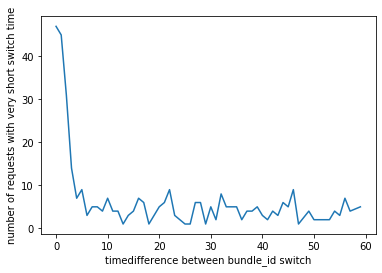

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
bundleplot=botbundle.groupby("timefod").count().orderBy("timefod",ascending=True)
plotbundle_pandas = bundleplot.toPandas()
y_pos= plotbundle_pandas['count']
x= plotbundle_pandas['timefod']
plt.plot(x,y_pos)
plt.xlabel('timedifference between bundle_id switch')
plt.ylabel('number of requests with very short switch time')

<h1><center>-------</center></h1>

## Idea 6 - IP based Broad Filtering
#### Multiple requests from an IP at same Timestamp
 - Filter the IPs' that sent multiple requests at same timestamp.

In [71]:
fraud_timestampl=sample_rtb_bids_stream_df.groupby("ip","timestamp").count()
fraud_ipl=fraud_timestampl.filter("count > '1'")
display(fraud_ipl)

,ip,timestamp,count
0,73.126.74.158,2019-05-01 03:45:20,2
1,71.232.54.81,2019-05-01 03:59:40,2
2,99.68.32.252,2019-05-01 01:45:48,2
3,75.147.11.105,2019-05-01 02:23:27,2
4,73.114.198.0,2019-05-01 03:57:27,2
5,172.58.217.158,2019-05-01 03:39:07,2
6,107.72.162.57,2019-05-01 01:05:53,2
7,76.100.188.150,2019-05-01 01:03:23,2
8,99.203.17.46,2019-05-01 01:08:36,2
9,186.86.31.17,2019-05-01 03:07:40,2


In [72]:
ipcountl=fraud_ipl.withColumnRenamed("count","reqcount").groupBy("reqcount").count()
display(ipcountl)

,reqcount,count
0,3,10
1,2,642
2,4,1


([<matplotlib.axis.XTick at 0x7fb3b0003518>,
 <a list of 3 Text xticklabel objects>)

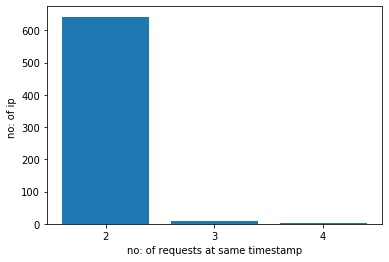

In [73]:
ipcountl_pandas = ipcountl.toPandas()
y_pos= ipcountl_pandas['count']
x= ipcountl_pandas['reqcount']
plt.bar(x,y_pos)
plt.xlabel('no: of requests at same timestamp')
plt.ylabel('no: of ip ')
plt.xticks(x, ('3','2','4','5'))

<h1><center>----END----</center></h1>